In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
import random

#Seed intialization
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Pre-processing

In [ ]:
train = pd.read_csv("./Data/Google_Stock_Price_Train.csv")
test = pd.read_csv("./Data/Google_Stock_Price_Test.csv")


train['Date']=pd.to_datetime(train['Date'])
train['Volume'] = train['Volume'].str.replace(',', '').astype(float)
train['Close'] = train['Close'].str.replace(',', '').astype(float)


train_backup = train.copy()

test['Date']=pd.to_datetime(test['Date'])
test['Volume'] = test['Volume'].str.replace(',', '').astype(float)

split_index = int(len(train) * 0.8)
train_set = train[:split_index]
val = train[split_index:] 
train = train_set
print("Training Set Shape:", train.shape)
print("Validation Set Shape:", val.shape)
print("Test Set Shape:", test.shape)
print("Train backup:",train_backup.shape)

Training Set Shape: (1006, 6)
Validation Set Shape: (252, 6)
Test Set Shape: (20, 6)
Train backup: (1258, 6)


In [4]:
train = train.loc[:, ["Open"]].values
val = val.loc[:, ["Open"]].values
test = test.loc[:, ["Open"]].values

train_backup = train_backup.loc[:, ["Open"]].values

## Visualization before pre-processing

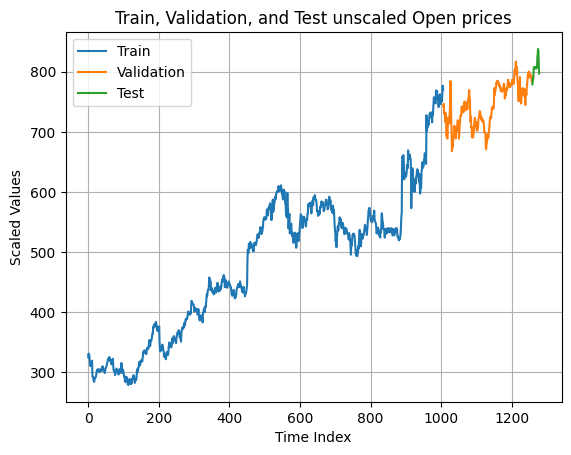

In [ ]:
val_start_index = len(train)
test_start_index = val_start_index + len(val)

train_indices = np.arange(len(train))
val_indices = np.arange(val_start_index, val_start_index + len(val))
test_indices = np.arange(test_start_index, test_start_index + len(test))

#Plotting
plt.plot(train_indices, train, label='Train')
plt.plot(val_indices, val, label='Validation')
plt.plot(test_indices, test, label='Test')

plt.legend()
plt.xlabel("Time Index")
plt.ylabel("Scaled Values")
plt.title("Train, Validation, and Test unscaled Open prices")
plt.grid()
plt.show()

## Visualization after pre-processing

In [6]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)


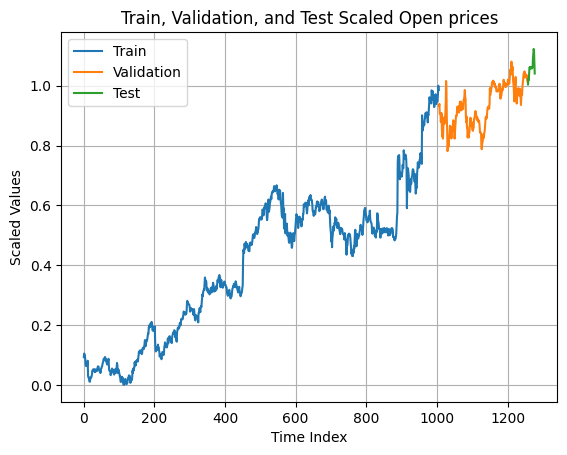

In [ ]:
val_start_index = len(train_scaled)
test_start_index = val_start_index + len(val_scaled)

train_indices = np.arange(len(train_scaled))
val_indices = np.arange(val_start_index, val_start_index + len(val_scaled))
test_indices = np.arange(test_start_index, test_start_index + len(test_scaled))

#Plotting
plt.plot(train_indices, train_scaled, label='Train')
plt.plot(val_indices, val_scaled, label='Validation')
plt.plot(test_indices, test_scaled, label='Test')

plt.legend()
plt.xlabel("Time Index")
plt.ylabel("Scaled Values")
plt.title("Train, Validation, and Test Scaled Open prices")
plt.grid()
plt.show()

In [ ]:
def create_sequences(data, timestep):
    X = []
    y = []
    for i  in range(timestep, len(data)):
        X.append(data[i-timestep:i, 0])
        y.append(data[i, 0])
    X, y = np.array(X), np.array(y)
    return np.reshape(X, (X.shape[0], X.shape[1], 1)), y

window = 7

X_train, y_train = create_sequences(train_scaled,window )
X_val, y_val = create_sequences(val_scaled,window )
X_test, y_test = create_sequences(test_scaled,window )

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(999, 7, 1) (999,)
(245, 7, 1) (245,)
(13, 7, 1) (13,)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_loss_curves(history):
    #Loss values
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    #Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss',)
    
    #Labels and title
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    
    plt.show()


def evaluate_models(model, X, y):


    loss = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Loss (Mean Squared Error): {loss}")

    rmse = np.sqrt(loss)
    print(f"Validation RMSE: {rmse:.4f}")
    pred = model.predict(X, verbose=0).reshape(-1)

    plt.figure(figsize=(10,6))
    plt.plot(y_val, label='True Values', color='blue')
    plt.plot(pred, label='Predicted Values', color='red', )
    plt.title('True vs Predicted Values')
    plt.xlabel('Samples')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


## Vanilla RNN Baseline

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

model_2 = Sequential()

#First RNN layer
model_2.add(SimpleRNN(units = 50, activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_2.add(Dropout(0.25)) 

model_2.add(SimpleRNN(units = 50, activation='tanh', return_sequences = False, input_shape = (X_train.shape[1], 1)))
model_2.add(Dropout(0.25)) 

model_2.add(Dense(units = 1))

model_2.compile(optimizer = 'adam', loss = 'mean_squared_error')

history_2 = model_2.fit(X_train, y_train, epochs = 10, batch_size = 4, validation_data  = (X_val,y_val))

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2416 - val_loss: 0.0670
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0201 - val_loss: 0.0104
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0110 - val_loss: 0.0038
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - val_loss: 0.0014
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0078 - val_loss: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0062 - val_loss: 0.0014
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - val_loss: 8.6734e-04
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032 - val_loss: 0.0022


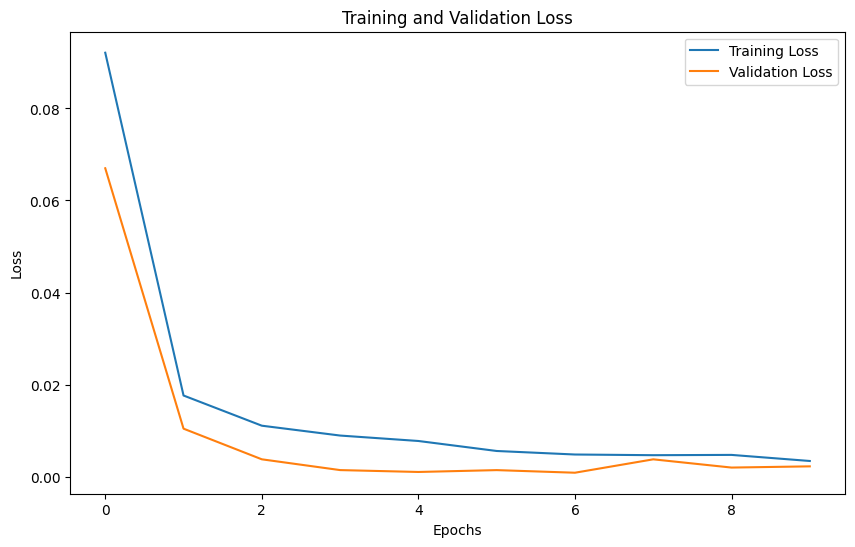

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 
0.0022496646270155907
Validation Loss (Mean Squared Error): 0.0022496646270155907
Validation RMSE: 0.0474


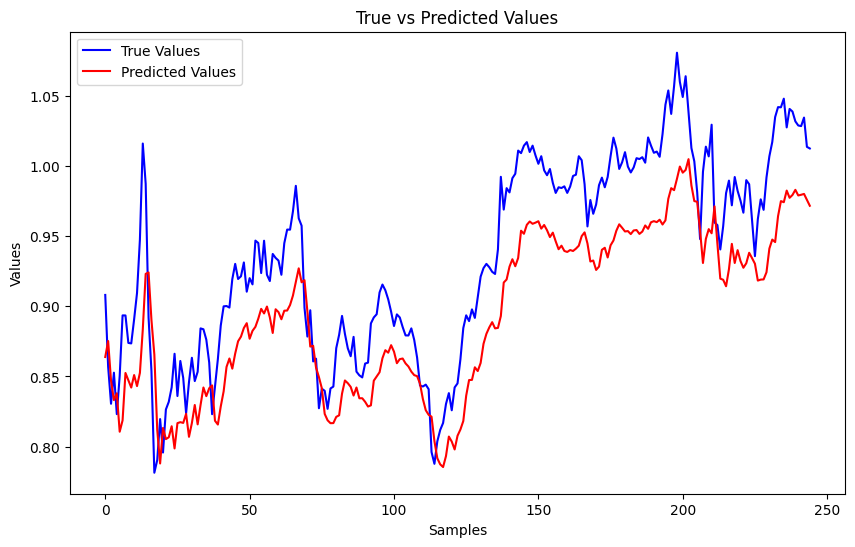

In [ ]:
plot_loss_curves(history=history_2)
print(model_2.evaluate(X_val, y_val))
evaluate_models(model_2, X_val, y_val)

## Vanilla RNN Finetuning

In [ ]:
def create_rnn_models(layers, units, shape, window):
    model = tf.keras.Sequential()
    for i in range(layers):
        return_seq = i < layers - 1
        model.add(tf.keras.layers.LSTM(units, return_sequences=return_seq, input_shape=shape if i == 0 else None))
    model.add(tf.keras.layers.Dense(1))
    return model

In [15]:
X_val.shape, y_val.shape

((245, 7, 1), (245,))

In [ ]:
def evaluate_models(model, X, y):

    #Loss
    loss = model.evaluate(X, y, verbose=0)
    print(f"Validation Loss (Mean Squared Error): {loss}")

    #Predictions
    pred = model.predict(X, verbose=0).reshape(-1)
    print(f"Shapes - True: {y.shape}, Predicted: {pred.shape}")

    #RMSE
    rmse = np.sqrt(mean_squared_error(y, pred))
    print(f"Validation RMSE: {rmse:.4f}")

    #Results
    plt.figure(figsize=(10, 6))
    plt.plot(y, label='True Values', color='blue')
    plt.plot(pred, label='Predicted Values', color='red')
    plt.title('True vs Predicted Values')
    plt.xlabel('Samples')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

In [ ]:
import itertools
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import numpy as np

#Track best model
best_model = None
best_rmse = float('inf')
best_config = {}

windows = [1,3,5,7]
units = [10, 50, 100]
layers = [2,3,5]
 
combinations = itertools.product(windows, units, layers)

for combination in combinations:
    window, unit, layer = combination
    print(f"Window : {window}, Unit: {unit}, Layer: {layer}")
    
    model = create_rnn_models(layers=layer, units=unit, shape=(X_train.shape[1], 1), window=window)
    model.compile(optimizer='adam', loss='mean_squared_error')

    #Early stopping
    history = model.fit(
        X_train, 
        y_train, 
        epochs=10,   
        batch_size=4, 
        validation_data=(X_val, y_val), 
        verbose=2
    )

    #Predict on val
    pred = model.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, pred.reshape(-1)))
    print(f"RMSE of the model: {rmse}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        
        # Update dictionary
        best_config = {'window': window, 'units': unit, 'layers': layer}

        print(f"New Best Model Found: Window={window}, Units={unit}, Layers={layer} - RMSE: {rmse}")

print("Best model configuration:", best_config)

Window : 1, Unit: 10, Layer: 2
Epoch 1/10
250/250 - 6s - 25ms/step - loss: 0.0386 - val_loss: 0.0075
Epoch 2/10
250/250 - 1s - 5ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3/10
250/250 - 1s - 5ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 4/10
250/250 - 1s - 5ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 5/10
250/250 - 1s - 5ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 6/10
250/250 - 1s - 4ms/step - loss: 0.0010 - val_loss: 0.0023
Epoch 7/10
250/250 - 1s - 5ms/step - loss: 9.9238e-04 - val_loss: 0.0022
Epoch 8/10
250/250 - 1s - 5ms/step - loss: 9.7467e-04 - val_loss: 0.0022
Epoch 9/10
250/250 - 1s - 5ms/step - loss: 9.5593e-04 - val_loss: 0.0021
Epoch 10/10
250/250 - 1s - 5ms/step - loss: 9.3641e-04 - val_loss: 0.0020
RMSE of the model: 0.04493011969497987
New Best Model Found: Window=1, Units=10, Layers=2 - RMSE: 0.04493011969497987
Window : 1, Unit: 10, Layer: 3
Epoch 1/10
250/250 - 8s - 33ms/step - loss: 0.0330 - val_loss: 0.0016
Epoch 2/10
250/250 - 2s - 7ms/step - loss:

## Vanilla RNN Test set Evaluation

Train shapes - X: (1251, 7, 1), y: (1251,)
Test shapes - X: (13, 7, 1), y: (13,)
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0238 - val_loss: 0.0055
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011 - val_loss: 0.0021
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0010 - val_loss: 0.0028
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.7324e-04 - val_loss: 0.0035
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.9860e-04 - val_loss: 0.0037
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.3051e-04 - val_loss: 0.0036
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.6810e-04 - val_loss: 0.0034


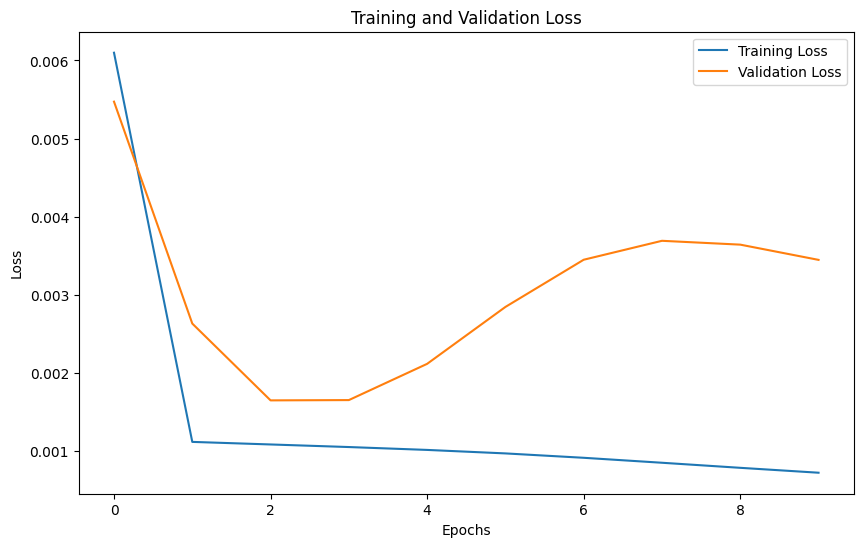

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0034
0.0034483703784644604
Validation Loss (Mean Squared Error): 0.0034483703784644604
Shapes - True: (13,), Predicted: (13,)
Validation RMSE: 0.0587


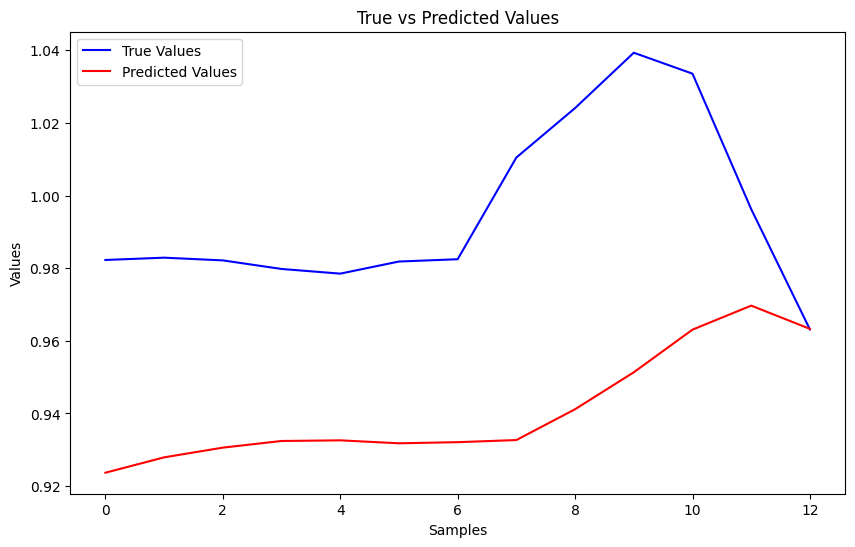

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled_full = scaler.fit_transform(train_backup)
test_scaled = scaler.transform(test)

X_train_full, y_train_full = create_sequences(train_scaled_full,best_config['window'] )
X_test, y_test = create_sequences(test_scaled,best_config['window'] )

print(f"Train shapes - X: {X_train_full.shape}, y: {y_train_full.shape}")
print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

model_3 = create_rnn_models(layers = best_config['layers'], 
                            units=best_config['units'],
                            shape = (X_train_full.shape[1], 1),
                             window=best_config['window'] )
model_3.compile(optimizer = 'adam', loss = 'mean_squared_error')
history_3 = model_3.fit(X_train_full, y_train_full, epochs = 10, batch_size = 4, validation_data  = (X_test,y_test))

plot_loss_curves(history=history_3)
print(model_3.evaluate(X_test, y_test))
evaluate_models(model_3, X_test, y_test)

## GRU Baseline

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1982 - val_loss: 0.2125
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0386 - val_loss: 0.1170
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0198 - val_loss: 0.0616
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0086 - val_loss: 0.0304
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0156
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0013 - val_loss: 0.0096
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0420e-04 - val_loss: 0.0074
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0341e-04 - val_loss: 0.0065
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.7173e-04 - val_loss: 0.0061
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.5029e-04 - val_loss: 0.0059


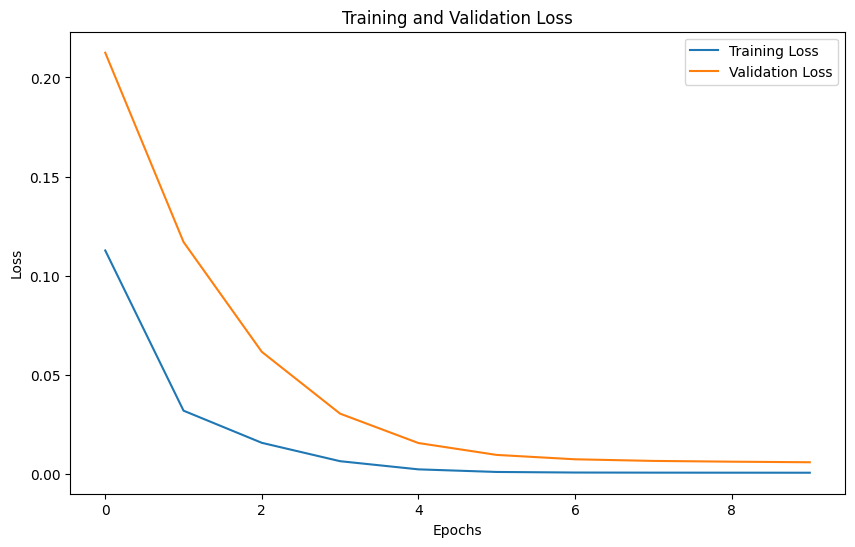

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044 
0.0058588553220033646
Validation Loss (Mean Squared Error): 0.0058588553220033646
Shapes - True: (245,), Predicted: (245,)
Validation RMSE: 0.0765


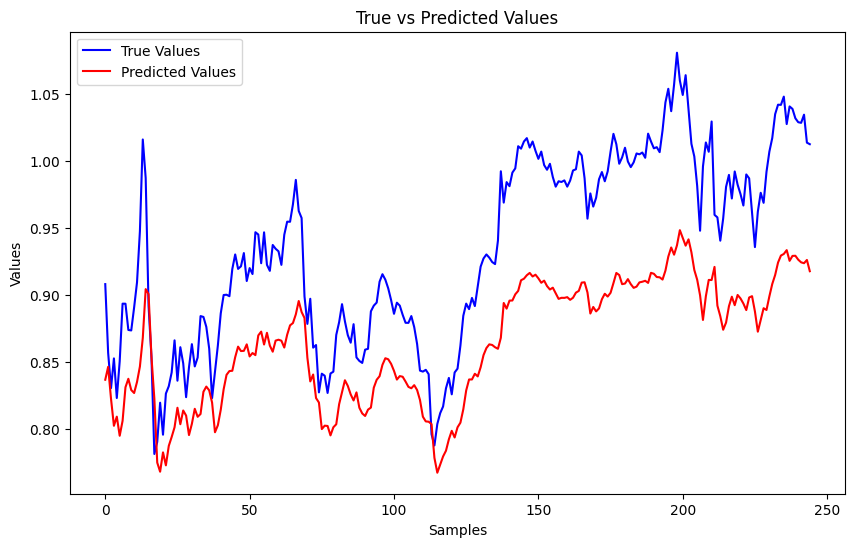

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

#Initialize
model_4 = Sequential()

model_4.add(GRU(units=2, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], 1)))

model_4.add(Dense(units=1))

model_4.compile(optimizer='adam', loss='mean_squared_error')

history_4 = model_4.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_val, y_val))

plot_loss_curves(history=history_4)
print(model_4.evaluate(X_val, y_val))
evaluate_models(model_4, X_val, y_val)

## GRU Finetuning

In [ ]:
def create_gru_models(layers, units, shape, window):
    model = tf.keras.Sequential()
    for i in range(layers):
        return_seq = i < layers - 1
        model.add(tf.keras.layers.GRU(units, return_sequences=return_seq, input_shape=shape if i == 0 else None))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
#Track best model
best_model = None
best_rmse = float('inf')
best_config = {}

windows = [1,3,5,7]
units = [10, 50, 100]
layers = [2,3,5]

combinations = itertools.product(windows, units, layers)

for combination in combinations:
    window, unit, layer = combination
    print(f"Window : {window}, Unit: {unit}, Layer: {layer}")
    
    model = create_gru_models(layers=layer, units=unit, shape=(X_train.shape[1], 1), window=window)
    model.compile(optimizer='adam', loss='mean_squared_error')

    #Early stopping
    history = model.fit(
        X_train, 
        y_train, 
        epochs=10,   
        batch_size=4, 
        validation_data=(X_val, y_val),
        verbose=2
    )

    # Predict val
    pred = model.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, pred.reshape(-1)))
    print(f"RMSE of the model: {rmse}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        
        #Update dictionary
        best_config = {'window': window, 'units': unit, 'layers': layer}

        print(f"New Best Model Found: Window={window}, Units={unit}, Layers={layer} - RMSE: {rmse}")

print("Best model configuration:", best_config)

Window : 1, Unit: 10, Layer: 2
Epoch 1/10
250/250 - 6s - 22ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 2/10
250/250 - 1s - 6ms/step - loss: 6.1897e-04 - val_loss: 0.0026
Epoch 3/10
250/250 - 1s - 6ms/step - loss: 5.6428e-04 - val_loss: 0.0021
Epoch 4/10
250/250 - 1s - 6ms/step - loss: 5.1226e-04 - val_loss: 0.0017
Epoch 5/10
250/250 - 1s - 6ms/step - loss: 4.7592e-04 - val_loss: 0.0014
Epoch 6/10
250/250 - 1s - 6ms/step - loss: 4.5165e-04 - val_loss: 0.0012
Epoch 7/10
250/250 - 1s - 6ms/step - loss: 4.3273e-04 - val_loss: 9.3974e-04
Epoch 8/10
250/250 - 1s - 6ms/step - loss: 4.1631e-04 - val_loss: 7.8507e-04
Epoch 9/10
250/250 - 1s - 6ms/step - loss: 4.0173e-04 - val_loss: 6.7924e-04
Epoch 10/10
250/250 - 1s - 6ms/step - loss: 3.8898e-04 - val_loss: 6.0746e-04
RMSE of the model: 0.024646782447850214
New Best Model Found: Window=1, Units=10, Layers=2 - RMSE: 0.024646782447850214
Window : 1, Unit: 10, Layer: 3
Epoch 1/10
250/250 - 9s - 36ms/step - loss: 0.0148 - val_loss: 0.0043
Epoc

## GRU Test set Evaluation

Train shapes - X: (1253, 5, 1), y: (1253,)
Test shapes - X: (15, 5, 1), y: (15,)
Epoch 1/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0121 - val_loss: 0.0011
Epoch 2/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5895e-04 - val_loss: 0.0011
Epoch 3/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.5742e-04 - val_loss: 0.0010
Epoch 4/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.3065e-04 - val_loss: 0.0010
Epoch 5/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.0053e-04 - val_loss: 9.4972e-04
Epoch 6/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.7138e-04 - val_loss: 8.9264e-04
Epoch 7/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.4417e-04 - val_loss: 8.3548e-04
Epoch 8/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.1913e-04 - val_loss: 7.8118e-04
Epoch 9/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9663e-04 - val_loss: 7.3269e-04
Epoch 10/10
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7722e-04 - val_loss: 6.9233e-0

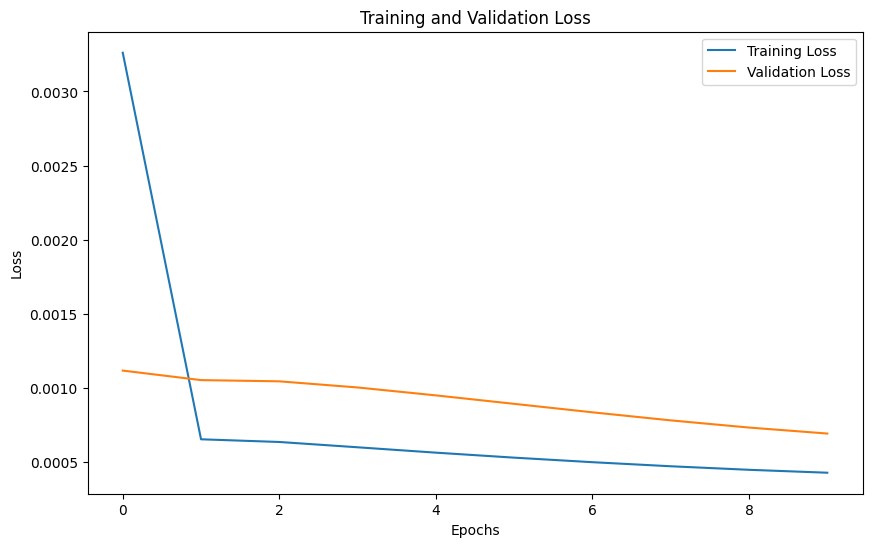

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.9233e-04
0.0006923311739228666
Validation Loss (Mean Squared Error): 0.0006923311739228666
Shapes - True: (15,), Predicted: (15,)
Validation RMSE: 0.0263


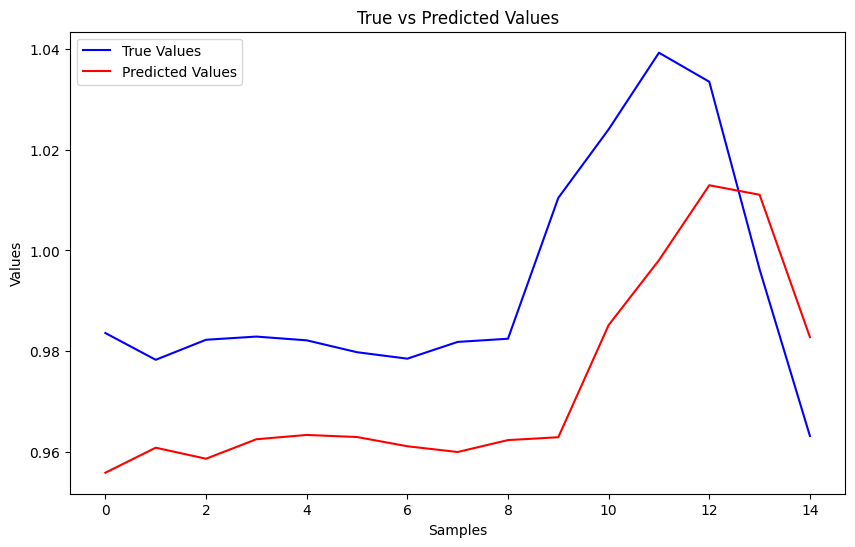

In [ ]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled_full = scaler.fit_transform(train_backup)
test_scaled = scaler.transform(test)

X_train_full, y_train_full = create_sequences(train_scaled_full,best_config['window'] )
X_test, y_test = create_sequences(test_scaled,best_config['window'] )

print(f"Train shapes - X: {X_train_full.shape}, y: {y_train_full.shape}")
print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")

model_5 = create_gru_models(layers = best_config['layers'], 
                            units=best_config['units'],
                            shape = (X_train_full.shape[1], 1),
                             window=best_config['window'] )
model_5.compile(optimizer = 'adam', loss = 'mean_squared_error')
history_5 = model_5.fit(X_train_full, y_train_full, epochs = 10, batch_size = 4, validation_data  = (X_test,y_test))

plot_loss_curves(history=history_5)
print(model_5.evaluate(X_test, y_test))
evaluate_models(model_5, X_test, y_test)


## LSTM Baseline

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0863 - val_loss: 0.1738
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0206 - val_loss: 0.0795
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0060 - val_loss: 0.0334
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0021 - val_loss: 0.0198
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0014 - val_loss: 0.0137
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - val_loss: 0.0097
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.7246e-04 - val_loss: 0.0069
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.2003e-04 - val_loss: 0.0050
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.1898e-04 - val_loss: 0.0037
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.5273e-04 - val_loss: 0.0028


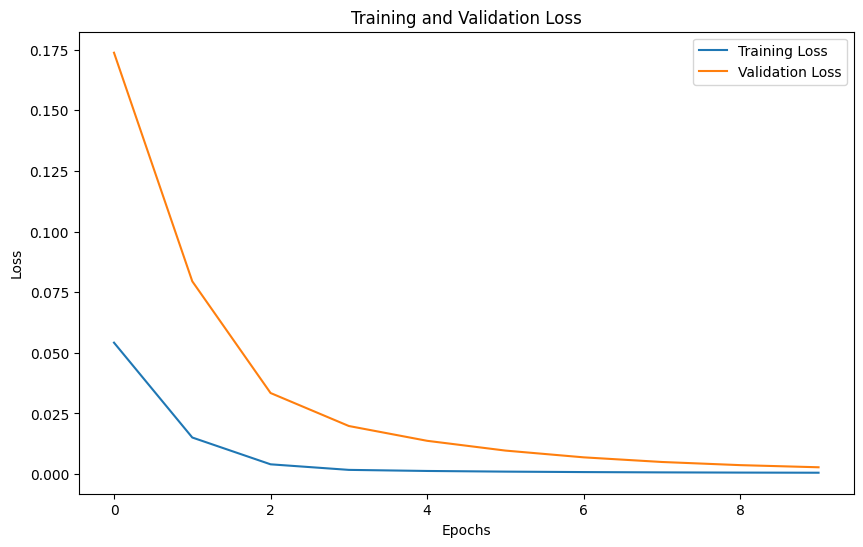

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 
0.0028183821123093367
Validation Loss (Mean Squared Error): 0.0028183821123093367
Shapes - True: (245,), Predicted: (245,)
Validation RMSE: 0.0531


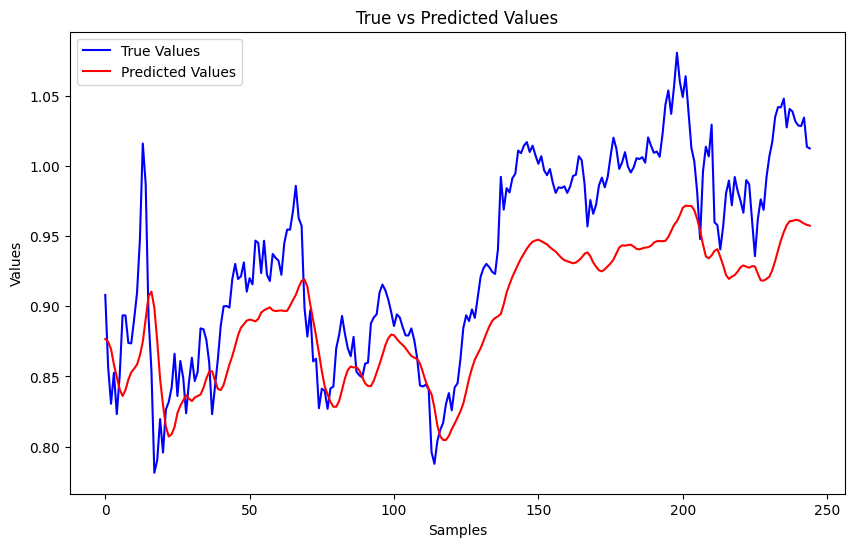

In [ ]:
from tensorflow.keras.layers import LSTM

model_7 = Sequential()

model_7.add(LSTM(units=1, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], 1)))

model_7.add(Dense(units=1))

model_7.compile(optimizer='adam', loss='mean_squared_error')

history_7 = model_7.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_val, y_val))

plot_loss_curves(history=history_7)

print(model_7.evaluate(X_val, y_val))

evaluate_models(model_7, X_val, y_val)

## LSTM Fine tuning

In [ ]:
def create_lstm_models(layers, units, shape, window):
    model = tf.keras.Sequential()
    for i in range(layers):
        return_seq = i < layers - 1
        model.add(tf.keras.layers.LSTM(units, return_sequences=return_seq, input_shape=shape if i == 0 else None))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
#Track the best model
best_model = None
best_rmse = float('inf') 
best_config = {} 

windows = [1,3,5,7]
units = [10]
layers = [1]

combinations = itertools.product(windows, units, layers)

#Iterate combinations
for combination in combinations:
    window, unit, layer = combination
    print(f"Window : {window}, Unit: {unit}, Layer: {layer}")
    
    model = create_lstm_models(layers=layer, units=unit, shape=(X_train.shape[1], 1), window=window)
    model.compile(optimizer='adam', loss='mean_squared_error')

    #Early stopping
    history = model.fit(
        X_train, 
        y_train, 
        epochs=10,   
        batch_size=4, 
        validation_data=(X_val, y_val),
        verbose=2
    )

    #Predict val
    pred = model.predict(X_val, verbose=0)
    rmse = np.sqrt(mean_squared_error(y_val, pred.reshape(-1)))
    print(f"RMSE of the model: {rmse}")

    if rmse < best_rmse:
        best_rmse = rmse
        best_model = model
        
        #Update dictionary
        best_config = {'window': window, 'units': unit, 'layers': layer}

        print(f"New Best Model Found: Window={window}, Units={unit}, Layers={layer} - RMSE: {rmse}")

print("Best model configuration:", best_config)

Window : 1, Unit: 10, Layer: 1
Epoch 1/10
250/250 - 3s - 13ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 2/10
250/250 - 1s - 4ms/step - loss: 5.7264e-04 - val_loss: 0.0013
Epoch 3/10
250/250 - 1s - 4ms/step - loss: 5.5677e-04 - val_loss: 0.0011
Epoch 4/10
250/250 - 1s - 3ms/step - loss: 5.4765e-04 - val_loss: 0.0010
Epoch 5/10
250/250 - 1s - 4ms/step - loss: 5.3836e-04 - val_loss: 9.7957e-04
Epoch 6/10
250/250 - 1s - 4ms/step - loss: 5.2773e-04 - val_loss: 9.6062e-04
Epoch 7/10
250/250 - 1s - 4ms/step - loss: 5.1616e-04 - val_loss: 9.4645e-04
Epoch 8/10
250/250 - 1s - 4ms/step - loss: 5.0415e-04 - val_loss: 9.3441e-04
Epoch 9/10
250/250 - 1s - 4ms/step - loss: 4.9208e-04 - val_loss: 9.2330e-04
Epoch 10/10
250/250 - 1s - 3ms/step - loss: 4.8021e-04 - val_loss: 9.1214e-04
RMSE of the model: 0.030201700047541205
New Best Model Found: Window=1, Units=10, Layers=1 - RMSE: 0.030201700047541205
Window : 3, Unit: 10, Layer: 1
Epoch 1/10
250/250 - 3s - 12ms/step - loss: 0.0198 - val_loss: 9.6

## LSTM Test set Evaluation

Train shapes - X: (1257, 1, 1), y: (1257,)
Test shapes - X: (19, 1, 1), y: (19,)
Epoch 1/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1851 - val_loss: 0.0874
Epoch 2/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0254 - val_loss: 0.0205
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0059 - val_loss: 0.0013
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8394e-04 - val_loss: 2.4277e-04
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2168e-04 - val_loss: 2.3891e-04
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1827e-04 - val_loss: 2.3836e-04
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1562e-04 - val_loss: 2.4040e-04
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1308e-04 - val_loss: 2.4480e-04
Epoch 9/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1092e-04 - val_loss: 2.5067e-04
Epoch 10/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.0932e-04 - val_loss: 2.5705e-04


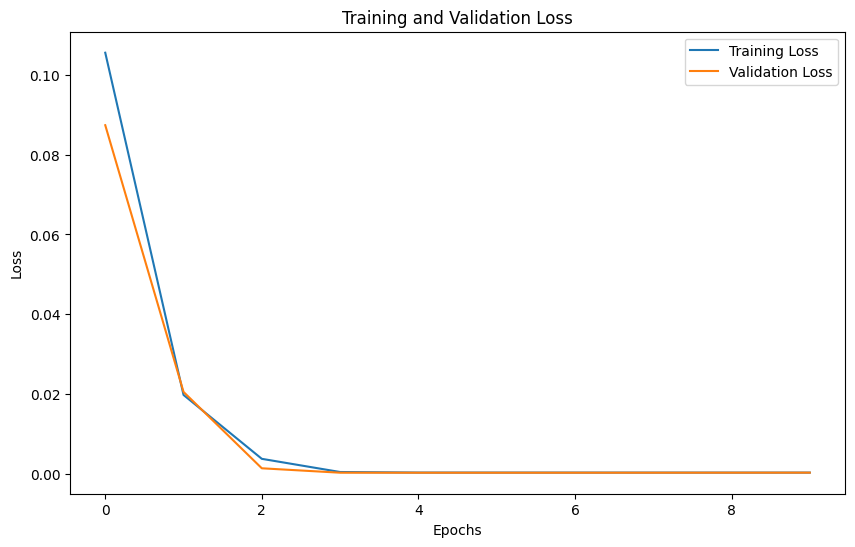

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.5705e-04
0.0002570517535787076
Validation Loss (Mean Squared Error): 0.0002570517535787076
Shapes - True: (19,), Predicted: (19,)
Validation RMSE: 0.0160


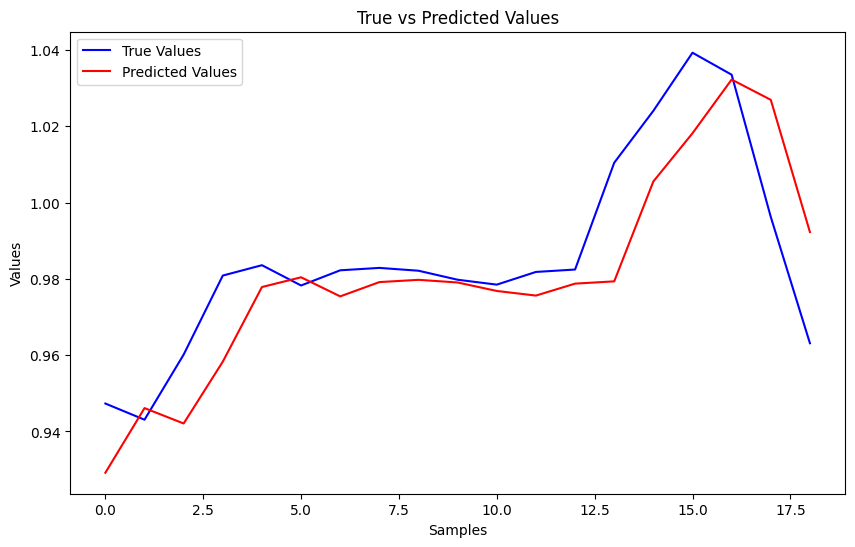

In [26]:
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled_full = scaler.fit_transform(train_backup)
test_scaled = scaler.transform(test)

X_train_full, y_train_full = create_sequences(train_scaled_full,best_config['window'] )
X_test, y_test = create_sequences(test_scaled,best_config['window'] )



print(f"Train shapes - X: {X_train_full.shape}, y: {y_train_full.shape}")
print(f"Test shapes - X: {X_test.shape}, y: {y_test.shape}")


model_8 = create_lstm_models(layers = best_config['layers'], 
                            units=best_config['units'],
                            shape = (X_train_full.shape[1], 1),
                             window=best_config['window'] )
model_8.compile(optimizer = 'adam', loss = 'mean_squared_error')
history_8 = model_8.fit(X_train_full, y_train_full, epochs = 10, batch_size = 4, validation_data  = (X_test,y_test))


plot_loss_curves(history=history_8)
print(model_8.evaluate(X_test, y_test))
evaluate_models(model_8, X_test, y_test)
